In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
import config

In [2]:
if config.USE_UNET: import unet as autoencoder
else: import convolutional_autoencoder as autoencoder

In [3]:
# Load the encoder model
def load_encoder(model_path, device):
    model = autoencoder.AutoEncoder()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.encoder
    model = model.to(device)
    return model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
autoencoder_save_path = 'best_models/h1_80-10-10_Autoencoder.pth'  # Replace with your actual encoder path
encoder = load_encoder(autoencoder_save_path, device)
encoder.to(device)
encoder.eval()

Encoder(
  (inc): InConv(
    (conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): Down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm

In [6]:
data_transforms = {
    'bce': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
    'mse': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.4641, 0.4891, 0.4096], [0.1883, 0.1621, 0.2068])
    ])
}

In [7]:
full_dataset = datasets.ImageFolder(config.BASE_DIR_NOISY if config.USE_DENOISING_AUTOENCODER else config.BASE_DIR_RAW, transform=data_transforms[config.AE_TRANSFORMS])
data = DataLoader(full_dataset, batch_size=config.AE_BATCH_SIZE, shuffle=True)

In [8]:
tsne_labels = []
latent_vectors = []

with torch.no_grad():
  i = 0
  for image, label in tqdm(data):
    tsne_labels.append(label.numpy())
    image = image.to(device)
    latents = encoder(image)
    
    if config.USE_UNET:
       latents = latents[4].cpu().numpy()
    else:
       latents = latents.cpu().numpy()
	   
    latent_vectors.append(latents.reshape(latents.shape[0], -1))
    i += 1
    if i >= 30:
      break

  5%|▌         | 99/1922 [00:09<02:47, 10.86it/s]


In [9]:
latent_vectors = np.concatenate(latent_vectors, axis=0)
labels = np.concatenate(tsne_labels, axis=0)

C:\Users\dylan\AppData\Local\Temp\ipykernel_41040\2212557025.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


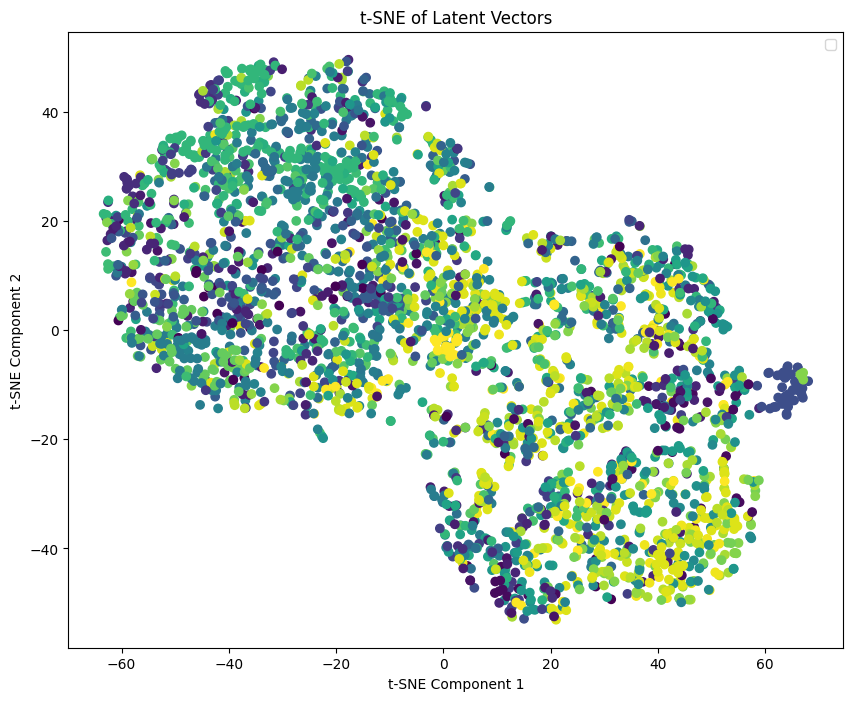

In [10]:
# Apply PCA
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(latent_vectors)

# Plot the results
plt.figure(figsize=(10, 8))

scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis')

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of Latent Vectors')
plt.legend()
plt.show()

In [11]:
writer = SummaryWriter('runs/latent_vectors')

np.savetxt('metadata.tsv', labels, delimiter='\t')
np.savetxt('latent_vectors.tsv', latent_vectors, delimiter='\t')

writer.add_embedding(latent_vectors, metadata=labels)
writer.close()